In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib.request
from bs4 import BeautifulSoup

---
## Shot chart scrape

In [59]:
# Send a get request and assign the response to a variable
response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/202104190PHI.html')

# Turn the undecoded content into a Beautiful Soup object and assign it to a variable
soup = BeautifulSoup(response.content, 'html.parser')  

# Scrape makes and misses by quarter
q1makes = soup.find_all(class_=f'tooltip q-1 p-curryst01 make')
q1misses = soup.find_all(class_=f'tooltip q-1 p-curryst01 miss')
q2makes = soup.find_all(class_=f'tooltip q-2 p-curryst01 make')
q2misses = soup.find_all(class_=f'tooltip q-2 p-curryst01 miss')
q3makes = soup.find_all(class_=f'tooltip q-3 p-curryst01 make')
q3misses = soup.find_all(class_=f'tooltip q-3 p-curryst01 miss')
q4makes = soup.find_all(class_=f'tooltip q-4 p-curryst01 make')
q4misses = soup.find_all(class_=f'tooltip q-4 p-curryst01 miss')

# Potential overtime too
q5makes = soup.find_all(class_=f'tooltip q-5 p-curryst01 make')
q5misses = soup.find_all(class_=f'tooltip q-5 p-curryst01 miss')
q6makes = soup.find_all(class_=f'tooltip q-6 p-curryst01 make')
q6misses = soup.find_all(class_=f'tooltip q-6 p-curryst01 miss')

# Add html from above to list and convert to string
shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
shot_list = [str(item) for item in shot_list]

# Store list in dataframe
shot_df = pd.DataFrame(data=shot_list)
shot_df

,0
0,"<div class=""tooltip q-1 p-curryst01 make"" styl..."
1,"<div class=""tooltip q-1 p-curryst01 make"" styl..."
2,"<div class=""tooltip q-1 p-curryst01 make"" styl..."
3,"<div class=""tooltip q-1 p-curryst01 make"" styl..."
4,"<div class=""tooltip q-2 p-curryst01 make"" styl..."
5,"<div class=""tooltip q-2 p-curryst01 make"" styl..."
6,"<div class=""tooltip q-2 p-curryst01 make"" styl..."
7,"<div class=""tooltip q-2 p-curryst01 make"" styl..."
8,"<div class=""tooltip q-3 p-curryst01 make"" styl..."
9,"<div class=""tooltip q-4 p-curryst01 make"" styl..."


---
## Features from shot chart

In [60]:
# Split string to separate the score before splitting on empty space
shot_df_ = shot_df[0].str.split(";",expand=True)

# Select and name useful columns from this split
shot_df_ = shot_df_.loc[:,(0,1,6,)]
shot_df_.columns = ['y_coordinate','x_coordinate','score']

# Split string on space to form new columns
shot_df = shot_df[0].str.split(" ",expand=True)

# Select and name remaing useful columns from this split
shot_df = shot_df.loc[:,(2,8,11,12,14)]
shot_df.columns = ['quarter','time','outcome','point_value','distance_ft']

# Concatenate back to one DataFrame
shot_df = pd.concat([shot_df, shot_df_], axis=1).sort_index()

# Format quarter as integer
shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

# Separate time into component parts and total as 'time_remaining_secs'
shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

# Sort shots in ascending order
shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])

# Convert 'outcome' to binary
shot_df['outcome'] = shot_df['outcome'].replace('made',1)
shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)

# Format 'point_value' as integer
shot_df['point_value'] = shot_df['point_value'].str.split("-", expand=True).drop(columns=1).astype(int)

# Convert 'distance_ft' to integer
shot_df['distance_ft'] = shot_df['distance_ft'].astype(int)

# Format coordinate points as integer
shot_df['x_coordinate'] = shot_df['x_coordinate'].str.split(":", expand=True).drop(columns=0)
shot_df['y_coordinate'] = shot_df['y_coordinate'].str.split(":", expand=True).drop(columns=0)
shot_df['x_coordinate'] = shot_df['x_coordinate'].str.split("p", expand=True).drop(columns=1).astype(int)
shot_df['y_coordinate'] = shot_df['y_coordinate'].str.split("p", expand=True).drop(columns=1).astype(int)

# Formatting player's team score before the shot
shot_df['score'] = shot_df['score'].str.split('"', expand=True).drop(columns=1)
shot_df['team_score'] = shot_df['score'].str.split('-', expand=True).drop(columns=1)

# Separating scores that have increased as a result of a made shot
shot_df['team_score_'] = shot_df['team_score'].str.split(' ', expand=True).loc[:,4] #####
shot_df['team_score'] = shot_df['team_score'].str.split(' ', expand=True).loc[:,3] #####

# Converting the text in those columns to zero
shot_df ['team_score'] = pd.to_numeric(shot_df['team_score'], errors='coerce').fillna(0).astype(int)
shot_df ['team_score_'] = pd.to_numeric(shot_df['team_score_'], errors='coerce').fillna(0).astype(int)

# Combining back to one column and subtracting point value of made shot to return the score when the shot was taken
shot_df['team_score'] = shot_df['team_score']+shot_df['team_score_']-(shot_df['outcome']*shot_df['point_value'])

# Formatting opposing teams score when the shot was taken
shot_df['opp_score'] = shot_df['score'].str.split('-', expand=True).drop(columns=0).astype(int)

# Calculating 'score_differential' when the shot was taken
shot_df['score_differential'] = shot_df['team_score']-shot_df['opp_score']

# Drop redundant columns
shot_df = shot_df.drop(columns = ['score', 'team_score', 'team_score_', 'opp_score'])

shot_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential
0,1,0,3,27,246,398,655,-4
1,1,0,3,26,241,87,606,-7
2,1,1,3,27,283,348,329,-10
3,1,1,3,28,282,112,305,-7
4,1,0,2,4,49,277,148,-7
5,1,1,2,2,39,222,104,-5
6,1,0,2,2,46,248,40,-3
7,1,1,3,28,313,264,0,-3
8,2,1,2,2,47,251,304,0
9,2,1,3,26,238,394,241,0


---
## Identifying shots following a make

In [61]:
# Create new column 'follows_make' that identifies shots following a made shot
shot_df['follows_make'] = shot_df['outcome'].shift()
shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

shot_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential,follows_make
0,1,0,3,27,246,398,655,-4,0
1,1,0,3,26,241,87,606,-7,0
2,1,1,3,27,283,348,329,-10,0
3,1,1,3,28,282,112,305,-7,1
4,1,0,2,4,49,277,148,-7,1
5,1,1,2,2,39,222,104,-5,0
6,1,0,2,2,46,248,40,-3,1
7,1,1,3,28,313,264,0,-3,0
8,2,1,2,2,47,251,304,0,1
9,2,1,3,26,238,394,241,0,1


---
## Identifying shots following two makes or two misses

In [62]:
# AFTER TWO MAKES OR TWO MISSES

# Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
shot_df['follows_streak'] = ~shot_df['follows_streak']

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_two_makes'
shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

# Create new columns 'follows_two_misses'
shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

shot_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential,follows_make,follows_two_makes,follows_two_misses
0,1,0,3,27,246,398,655,-4,0,0,0
1,1,0,3,26,241,87,606,-7,0,0,0
2,1,1,3,27,283,348,329,-10,0,0,1
3,1,1,3,28,282,112,305,-7,1,0,0
4,1,0,2,4,49,277,148,-7,1,1,0
5,1,1,2,2,39,222,104,-5,0,0,0
6,1,0,2,2,46,248,40,-3,1,0,0
7,1,1,3,28,313,264,0,-3,0,0,0
8,2,1,2,2,47,251,304,0,1,0,0
9,2,1,3,26,238,394,241,0,1,1,0


---
## Identifying shots following three makes or three misses

In [63]:
# Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_three_makes' and 'success_following_three_makes'
shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

# Create new columns 'follows_three_misses' and 'success_following_three_misses'
shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

shot_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential,follows_make,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses
0,1,0,3,27,246,398,655,-4,0,0,0,0,0
1,1,0,3,26,241,87,606,-7,0,0,0,0,0
2,1,1,3,27,283,348,329,-10,0,0,1,0,0
3,1,1,3,28,282,112,305,-7,1,0,0,0,0
4,1,0,2,4,49,277,148,-7,1,1,0,0,0
5,1,1,2,2,39,222,104,-5,0,0,0,0,0
6,1,0,2,2,46,248,40,-3,1,0,0,0,0
7,1,1,3,28,313,264,0,-3,0,0,0,0,0
8,2,1,2,2,47,251,304,0,1,0,0,0,0
9,2,1,3,26,238,394,241,0,1,1,0,0,0


---
## Identifying shots following four makes or four misses

In [64]:
# Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
shot_df['follows_streak'] = shot_df['follows_streak'].shift()
shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

# Intermediate columns to identify streaks of makes or misses
shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

# Create new columns 'follows_two_makes' and 'success_following_two_makes'
shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

# Create new columns 'follows_four_misses' and 'success_following_four_misses'
shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

# Drop intermediate columns
shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

shot_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential,follows_make,follows_two_makes,follows_two_misses,follows_three_makes,follows_three_misses,follows_four_makes,follows_four_misses
0,1,0,3,27,246,398,655,-4,0,0,0,0,0,0,0
1,1,0,3,26,241,87,606,-7,0,0,0,0,0,0,0
2,1,1,3,27,283,348,329,-10,0,0,1,0,0,0,0
3,1,1,3,28,282,112,305,-7,1,0,0,0,0,0,0
4,1,0,2,4,49,277,148,-7,1,1,0,0,0,0,0
5,1,1,2,2,39,222,104,-5,0,0,0,0,0,0,0
6,1,0,2,2,46,248,40,-3,1,0,0,0,0,0,0
7,1,1,3,28,313,264,0,-3,0,0,0,0,0,0,0
8,2,1,2,2,47,251,304,0,1,0,0,0,0,0,0
9,2,1,3,26,238,394,241,0,1,1,0,0,0,0,0


---
## Some other features

In [65]:
# Engineering some other features

shot_df['left_side'] = np.where(shot_df['x_coordinate']<250, True, False).astype(int)
shot_df['down_10'] = np.where(shot_df['score_differential']<=-10, True, False).astype(int)
shot_df['up_10'] = np.where(shot_df['score_differential']>10, True, False).astype(int)
shot_df['down_5'] = np.where(shot_df['score_differential']<=-5, True, False).astype(int)
shot_df['up_5'] = np.where(shot_df['score_differential']>5, True, False).astype(int)
shot_df['buzzer_beater'] = np.where(shot_df['time_remaining_secs']<5, True, False).astype(int)
shot_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential,follows_make,follows_two_makes,...,follows_three_makes,follows_three_misses,follows_four_makes,follows_four_misses,left_side,down_10,up_10,down_5,up_5,buzzer_beater
0,1,0,3,27,246,398,655,-4,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,3,26,241,87,606,-7,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,1,3,27,283,348,329,-10,0,0,...,0,0,0,0,0,1,0,1,0,0
3,1,1,3,28,282,112,305,-7,1,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,2,4,49,277,148,-7,1,1,...,0,0,0,0,0,0,0,1,0,0
5,1,1,2,2,39,222,104,-5,0,0,...,0,0,0,0,1,0,0,1,0,0
6,1,0,2,2,46,248,40,-3,1,0,...,0,0,0,0,1,0,0,0,0,0
7,1,1,3,28,313,264,0,-3,0,0,...,0,0,0,0,0,0,0,0,0,1
8,2,1,2,2,47,251,304,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,2,1,3,26,238,394,241,0,1,1,...,0,0,0,0,0,0,0,0,0,0


---
## Recreating shot chart

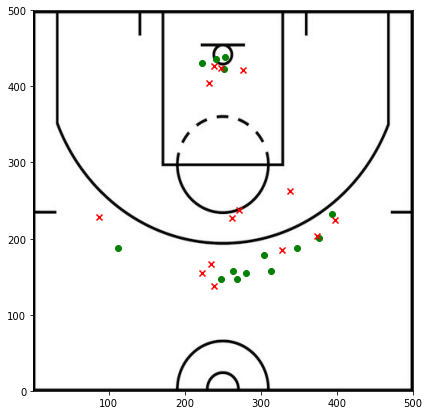

In [66]:
# Plot makes and misses
img = plt.imread("court.png")

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(img, extent=[1, 500, -1, 499])
ax.scatter(shot_df[shot_df['outcome']==1]['x_coordinate'], 470-shot_df[shot_df['outcome']==1]['y_coordinate'], marker='o', c='g')
ax.scatter(shot_df[shot_df['outcome']==0]['x_coordinate'], 470-shot_df[shot_df['outcome']==0]['y_coordinate'], marker='x', c='r')
plt.xlim(1,500)
plt.ylim(0,500)
plt.show()

---
## Season scrape function, concatenate to one long DataFrame

In [67]:
def season(code, abbr, year):
    
    '''

    '''
    shot_df_list = []
    
    ##### GETTING LIST OF GAMES #####
    
    # Send a get request and assign the response to a variable for a single team and season
    response = requests.get(f'https://www.basketball-reference.com/teams/{abbr}/{year}_games.html')
    
    # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
    soup = BeautifulSoup(response.content, 'html.parser')

    # Retrieve all tags that contain desired text and convert to string
    href_tags = soup.find_all(href=True)
    href_tags = [str(item) for item in href_tags]

    # Store in dataframe
    href_tags = pd.DataFrame(data=href_tags)

    # Filter for boxscores only
    searchfor = [f'boxscores/{year-1}',f'boxscores/{year}']
    href_tags = href_tags[href_tags[0].str.contains('|'.join(searchfor))].reset_index().drop(columns=['index'])

    # Split string to get desired output
    href_tags = href_tags[0].str.split("/",expand=True)
    href_tags = href_tags[2].str.split(".html",expand=True).drop(columns=1)

    # Convert array to list to loop through
    games = href_tags[0].tolist()
    
    
    ##### GETTING SHOTS FROM EACH GAME #####

    for game in games:
    
        # Send a get request and assign the response to a variable
        response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/{game}.html')
    
        # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
        soup = BeautifulSoup(response.content, 'html.parser')  
    
        # Scrape makes and misses by quarter
        q1makes = soup.find_all(class_=f'tooltip q-1 p-{code}01 make')
        q1misses = soup.find_all(class_=f'tooltip q-1 p-{code}01 miss')
        q2makes = soup.find_all(class_=f'tooltip q-2 p-{code}01 make')
        q2misses = soup.find_all(class_=f'tooltip q-2 p-{code}01 miss')
        q3makes = soup.find_all(class_=f'tooltip q-3 p-{code}01 make')
        q3misses = soup.find_all(class_=f'tooltip q-3 p-{code}01 miss')
        q4makes = soup.find_all(class_=f'tooltip q-4 p-{code}01 make')
        q4misses = soup.find_all(class_=f'tooltip q-4 p-{code}01 miss')
        
        # Potential OT too
        q5makes = soup.find_all(class_=f'tooltip q-5 p-{code}01 make')
        q5misses = soup.find_all(class_=f'tooltip q-5 p-{code}01 miss')
        q6makes = soup.find_all(class_=f'tooltip q-6 p-{code}01 make')
        q6misses = soup.find_all(class_=f'tooltip q-6 p-{code}01 miss')
        
        # Add html from above to list and convert to string
        shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
        shot_list = [str(item) for item in shot_list]
    
        # If list is empty, skip to next game...
        if not shot_list:
            pass
    
        # Otherwise, continue...
        else:
        
            ##### STORING SHOTS FROM EACH GAME IN A DATAFRAME #####

            # Store list in dataframe
            shot_df = pd.DataFrame(data=shot_list)

            # Split string to separate the score before splitting on empty space
            shot_df_ = shot_df[0].str.split(";",expand=True)

            # Select and name useful columns from this split
            shot_df_ = shot_df_.loc[:,(0,1,6,)]
            shot_df_.columns = ['y_coordinate','x_coordinate','score']

            # Split string on space to form new columns
            shot_df = shot_df[0].str.split(" ",expand=True)

            # Select and name remaing useful columns from this split
            shot_df = shot_df.loc[:,(2,8,11,12,14)]
            shot_df.columns = ['quarter','time','outcome','point_value','distance_ft']

            # Concatenate back to one DataFrame
            shot_df = pd.concat([shot_df, shot_df_], axis=1).sort_index()

            # Format quarter as integer
            shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

            # Separate time into component parts and total as 'time_remaining_secs'
            shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
            shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
            shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
            shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
            shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

            # Sort shots in ascending order
            shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])

            # Convert 'outcome' to binary
            shot_df['outcome'] = shot_df['outcome'].replace('made',1)
            shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)

            # Format 'point_value' as integer
            shot_df['point_value'] = shot_df['point_value'].str.split("-", expand=True).drop(columns=1).astype(int)

            # Convert 'distance_ft' to integer
            shot_df['distance_ft'] = shot_df['distance_ft'].astype(int)

            # Format coordinate points as integer
            shot_df['x_coordinate'] = shot_df['x_coordinate'].str.split(":", expand=True).drop(columns=0)
            shot_df['y_coordinate'] = shot_df['y_coordinate'].str.split(":", expand=True).drop(columns=0)
            shot_df['x_coordinate'] = shot_df['x_coordinate'].str.split("p", expand=True).drop(columns=1).astype(int)
            shot_df['y_coordinate'] = shot_df['y_coordinate'].str.split("p", expand=True).drop(columns=1).astype(int)

            # Formatting player's team score before the shot
            shot_df['score'] = shot_df['score'].str.split('"', expand=True).drop(columns=1)
            shot_df['team_score'] = shot_df['score'].str.split('-', expand=True).drop(columns=1)

            # Separating scores that have increased as a result of a made shot
            shot_df['team_score_'] = shot_df['team_score'].str.split(' ', expand=True).loc[:,4] #####
            shot_df['team_score'] = shot_df['team_score'].str.split(' ', expand=True).loc[:,3] #####

            # Converting the text in those columns to zero
            shot_df ['team_score'] = pd.to_numeric(shot_df['team_score'], errors='coerce').fillna(0).astype(int)
            shot_df ['team_score_'] = pd.to_numeric(shot_df['team_score_'], errors='coerce').fillna(0).astype(int)

            # Combining back to one column and subtracting point value of made shot to return the score when the shot was taken
            shot_df['team_score'] = shot_df['team_score']+shot_df['team_score_']-(shot_df['outcome']*shot_df['point_value'])

            # Formatting opposing teams score when the shot was taken
            shot_df['opp_score'] = shot_df['score'].str.split('-', expand=True).drop(columns=0).astype(int)

            # Calculating 'score_differential' when the shot was taken
            shot_df['score_differential'] = shot_df['team_score']-shot_df['opp_score']

            # Drop redundant columns
            shot_df = shot_df.drop(columns = ['score', 'team_score', 'team_score_', 'opp_score'])
            
            # AFTER A SINGLE MAKE OR MISS
        
            # Create new column 'follows_make' that identifies shots following a made shot
            shot_df['follows_make'] = shot_df['outcome'].shift()
            shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

            # AFTER TWO MAKES OR TWO MISSES

            # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
            shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
            shot_df['follows_streak'] = shot_df['follows_streak'].shift()
            shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
            shot_df['follows_streak'] = ~shot_df['follows_streak']

            # Intermediate columns to identify streaks of makes or misses
            shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
            shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

            # Create new columns 'follows_two_makes'
            shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
            shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

            # Create new columns 'follows_two_misses'
            shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
            shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

            # Drop intermediate columns
            shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

            # AFTER THREE MAKES OR THREE MISSES

            # Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
            shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
            shot_df['follows_streak'] = shot_df['follows_streak'].shift()
            shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

            # Intermediate columns to identify streaks of makes or misses
            shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
            shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

            # Create new columns 'follows_three_makes' and 'success_following_three_makes'
            shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
            shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

            # Create new columns 'follows_three_misses' and 'success_following_three_misses'
            shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
            shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

            # Drop intermediate columns
            shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

            # AFTER FOUR MAKES OR FOUR MISSES

            # Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
            shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
            shot_df['follows_streak'] = shot_df['follows_streak'].shift()
            shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

            # Intermediate columns to identify streaks of makes or misses
            shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
            shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

            # Create new columns 'follows_two_makes' and 'success_following_two_makes'
            shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
            shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

            # Create new columns 'follows_four_misses' and 'success_following_four_misses'
            shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
            shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

            # Drop intermediate columns
            shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])
            
            shot_df['left_side'] = np.where(shot_df['x_coordinate']<250, True, False).astype(int)
            shot_df['down_10'] = np.where(shot_df['score_differential']<=-10, True, False).astype(int)
            shot_df['up_10'] = np.where(shot_df['score_differential']>10, True, False).astype(int)
            shot_df['down_5'] = np.where(shot_df['score_differential']<=-5, True, False).astype(int)
            shot_df['up_5'] = np.where(shot_df['score_differential']>5, True, False).astype(int)
            shot_df['buzzer_beater'] = np.where(shot_df['time_remaining_secs']<3, True, False).astype(int)
            
            shot_df['game'] = f'{game}'
            
            shot_df_list.append(shot_df)
               
    shot_df = pd.concat(shot_df_list)
  
    return shot_df

In [68]:
season_df = season('curryst','GSW', 2016)

In [69]:
season_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1916 entries, 0 to 18
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   quarter               1916 non-null   int64 
 1   outcome               1916 non-null   int64 
 2   point_value           1916 non-null   int64 
 3   distance_ft           1916 non-null   int64 
 4   y_coordinate          1916 non-null   int64 
 5   x_coordinate          1916 non-null   int64 
 6   time_remaining_secs   1916 non-null   int64 
 7   score_differential    1916 non-null   int64 
 8   follows_make          1916 non-null   int64 
 9   follows_two_makes     1916 non-null   int64 
 10  follows_two_misses    1916 non-null   int64 
 11  follows_three_makes   1916 non-null   int64 
 12  follows_three_misses  1916 non-null   int64 
 13  follows_four_makes    1916 non-null   int64 
 14  follows_four_misses   1916 non-null   int64 
 15  left_side             1916 non-null   in

In [70]:
season_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,score_differential,follows_make,follows_two_makes,...,follows_three_misses,follows_four_makes,follows_four_misses,left_side,down_10,up_10,down_5,up_5,buzzer_beater,game
0,1,1,2,3,61,252,656,1,0,0,...,0,0,0,0,0,0,0,0,0,201510270GSW
1,1,0,3,26,225,64,629,3,1,0,...,0,0,0,1,0,0,0,0,0,201510270GSW
2,1,0,2,2,39,260,574,-2,0,0,...,0,0,0,0,0,0,0,0,0,201510270GSW
3,1,1,3,27,223,43,553,0,0,0,...,0,0,0,1,0,0,0,0,0,201510270GSW
4,1,1,2,0,38,236,431,1,1,0,...,0,0,0,1,0,0,0,0,0,201510270GSW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,4,0,2,10,73,329,338,2,1,0,...,0,0,0,0,0,0,0,0,0,201606190GSW
15,4,0,3,27,233,417,246,0,0,0,...,0,0,0,0,0,0,0,0,0,201606190GSW
16,4,0,3,26,292,241,74,0,0,0,...,0,0,0,1,0,0,0,0,0,201606190GSW
17,4,0,3,26,267,354,31,-3,0,0,...,1,0,0,0,0,0,0,0,0,201606190GSW


---
## EDA

In [71]:
print(f"Left side pct: {season_df[season_df['x_coordinate']<250]['outcome'].sum()/len(season_df[season_df['x_coordinate']<250])}")
print(f"Right side pct: {season_df[season_df['x_coordinate']>250]['outcome'].sum()/len(season_df[season_df['x_coordinate']>250])}")

Left side pct: 0.5191768007483629
Right side pct: 0.4575645756457565


In [72]:
print(f"Down 10 pct: {season_df[season_df['score_differential']<-10]['outcome'].sum()/len(season_df[season_df['score_differential']<-10])}")
print(f"Up 10 pct: {season_df[season_df['score_differential']>10]['outcome'].sum()/len(season_df[season_df['score_differential']>10])}")

Down 10 pct: 0.45689655172413796
Up 10 pct: 0.5200945626477541


In [73]:
print(f"Down 5 pct: {season_df[season_df['score_differential']<-5]['outcome'].sum()/len(season_df[season_df['score_differential']<-5])}")
print(f"Up 5 pct: {season_df[season_df['score_differential']>5]['outcome'].sum()/len(season_df[season_df['score_differential']>5])}")

Down 5 pct: 0.4825174825174825
Up 5 pct: 0.5256756756756756


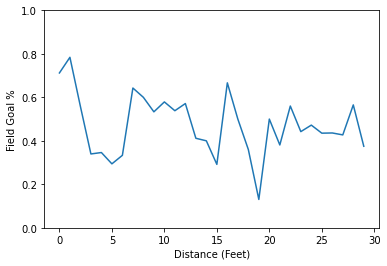

In [74]:
pct_list = []

for i in range(0,30):

    pct_list.append(season_df[season_df['distance_ft']==i]['outcome'].sum()/len(season_df[season_df['distance_ft']==i]))
    
plt.figure()
plt.plot(range(0,30), pct_list)
plt.xlabel('Distance (Feet)')
plt.ylabel('Field Goal %')
plt.ylim(0,1)
plt.show()

---
## Multiple years

In [86]:
def career(code, abbr, years):
    
    '''

    '''
    
    season_df_list = []
    
    for year in years:
    
        shot_df_list = []

        ##### GETTING LIST OF GAMES #####

        # Send a get request and assign the response to a variable for a single team and season
        response = requests.get(f'https://www.basketball-reference.com/teams/{abbr}/{year}_games.html')

        # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
        soup = BeautifulSoup(response.content, 'html.parser')

        # Retrieve all tags that contain desired text and convert to string
        href_tags = soup.find_all(href=True)
        href_tags = [str(item) for item in href_tags]

        # Store in dataframe
        href_tags = pd.DataFrame(data=href_tags)

        # Filter for boxscores only
        searchfor = [f'boxscores/{year-1}',f'boxscores/{year}']
        href_tags = href_tags[href_tags[0].str.contains('|'.join(searchfor))].reset_index().drop(columns=['index'])

        # Split string to get desired output
        href_tags = href_tags[0].str.split("/",expand=True)
        href_tags = href_tags[2].str.split(".html",expand=True).drop(columns=1)

        # Convert array to list to loop through
        games = href_tags[0].tolist()


        ##### GETTING SHOTS FROM EACH GAME #####

        for game in games:

            # Send a get request and assign the response to a variable
            response = requests.get(f'https://www.basketball-reference.com/boxscores/shot-chart/{game}.html')

            # Turn the undecoded content into a Beautiful Soup object and assign it to a variable
            soup = BeautifulSoup(response.content, 'html.parser')  

            # Scrape makes and misses by quarter
            q1makes = soup.find_all(class_=f'tooltip q-1 p-{code}01 make')
            q1misses = soup.find_all(class_=f'tooltip q-1 p-{code}01 miss')
            q2makes = soup.find_all(class_=f'tooltip q-2 p-{code}01 make')
            q2misses = soup.find_all(class_=f'tooltip q-2 p-{code}01 miss')
            q3makes = soup.find_all(class_=f'tooltip q-3 p-{code}01 make')
            q3misses = soup.find_all(class_=f'tooltip q-3 p-{code}01 miss')
            q4makes = soup.find_all(class_=f'tooltip q-4 p-{code}01 make')
            q4misses = soup.find_all(class_=f'tooltip q-4 p-{code}01 miss')

            # Potential OT too
            q5makes = soup.find_all(class_=f'tooltip q-5 p-{code}01 make')
            q5misses = soup.find_all(class_=f'tooltip q-5 p-{code}01 miss')
            q6makes = soup.find_all(class_=f'tooltip q-6 p-{code}01 make')
            q6misses = soup.find_all(class_=f'tooltip q-6 p-{code}01 miss')

            # Add html from above to list and convert to string
            shot_list = list(q1makes+q2makes+q3makes+q4makes+q5makes+q6makes+q1misses+q2misses+q3misses+q4misses+q5misses+q6misses)
            shot_list = [str(item) for item in shot_list]

            # If list is empty, skip to next game...
            if not shot_list:
                pass

            # Otherwise, continue...
            else:

                ##### STORING SHOTS FROM EACH GAME IN A DATAFRAME #####

                # Store list in dataframe
                shot_df = pd.DataFrame(data=shot_list)

                # Split string to separate the score before splitting on empty space
                shot_df_ = shot_df[0].str.split(";",expand=True)

                # Select and name useful columns from this split
                shot_df_ = shot_df_.loc[:,(0,1,6,)]
                shot_df_.columns = ['y_coordinate','x_coordinate','score']

                # Split string on space to form new columns
                shot_df = shot_df[0].str.split(" ",expand=True)

                # Select and name remaing useful columns from this split
                shot_df = shot_df.loc[:,(2,8,11,12,14)]
                shot_df.columns = ['quarter','time','outcome','point_value','distance_ft']

                # Concatenate back to one DataFrame
                shot_df = pd.concat([shot_df, shot_df_], axis=1).sort_index()

                # Format quarter as integer
                shot_df['quarter'] = shot_df['quarter'].str.slice(start=2).astype(int)

                # Separate time into component parts and total as 'time_remaining_secs'
                shot_df['minutes_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=1).astype(int)
                shot_df['seconds_remaining'] = shot_df['time'].str.split(":", expand=True).drop(columns=0)
                shot_df['seconds_remaining'] = shot_df['seconds_remaining'].str.slice(stop=-2).astype(int)
                shot_df['time_remaining_secs'] = shot_df['minutes_remaining']*60+shot_df['seconds_remaining']
                shot_df = shot_df.drop(columns= ['time', 'minutes_remaining', 'seconds_remaining'])

                # Sort shots in ascending order
                shot_df = shot_df.sort_values(by=['quarter','time_remaining_secs'], ascending=[True, False]).reset_index().drop(columns=['index'])

                # Convert 'outcome' to binary
                shot_df['outcome'] = shot_df['outcome'].replace('made',1)
                shot_df['outcome'] = shot_df['outcome'].replace('missed',0).astype(int)

                # Format 'point_value' as integer
                shot_df['point_value'] = shot_df['point_value'].str.split("-", expand=True).drop(columns=1).astype(int)

                # Convert 'distance_ft' to integer
                shot_df['distance_ft'] = shot_df['distance_ft'].astype(int)

                # Format coordinate points as integer
                shot_df['x_coordinate'] = shot_df['x_coordinate'].str.split(":", expand=True).drop(columns=0)
                shot_df['y_coordinate'] = shot_df['y_coordinate'].str.split(":", expand=True).drop(columns=0)
                shot_df['x_coordinate'] = shot_df['x_coordinate'].str.split("p", expand=True).drop(columns=1).astype(int)
                shot_df['y_coordinate'] = shot_df['y_coordinate'].str.split("p", expand=True).drop(columns=1).astype(int)

                # AFTER A SINGLE MAKE OR MISS

                # Create new column 'follows_make' that identifies shots following a made shot
                shot_df['follows_make'] = shot_df['outcome'].shift()
                shot_df['follows_make'] = shot_df['follows_make'].replace(np.nan,0).astype(int)

                # AFTER TWO MAKES OR TWO MISSES

                # Create new column 'follows_streak' that identifies shots following streaks of two makes or two misses
                shot_df['follows_streak'] = shot_df.outcome.ne(shot_df['outcome'].shift())
                shot_df['follows_streak'] = shot_df['follows_streak'].shift()
                shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,True)
                shot_df['follows_streak'] = ~shot_df['follows_streak']

                # Intermediate columns to identify streaks of makes or misses
                shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
                shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

                # Create new columns 'follows_two_makes'
                shot_df['follows_two_makes'] = shot_df.follows_streak == shot_df.new2
                shot_df['follows_two_makes'] = shot_df['follows_two_makes'].astype(int)

                # Create new columns 'follows_two_misses'
                shot_df['follows_two_misses'] = shot_df.follows_streak ^ shot_df.new2
                shot_df['follows_two_misses'] = shot_df['follows_two_misses'].astype(int)

                # Drop intermediate columns
                shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

                # AFTER THREE MAKES OR THREE MISSES

                # Create new column 'follows_streak' that identifies shots following streaks of three makes or three misses
                shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift())
                shot_df['follows_streak'] = shot_df['follows_streak'].shift()
                shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

                # Intermediate columns to identify streaks of makes or misses
                shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
                shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

                # Create new columns 'follows_three_makes' and 'success_following_three_makes'
                shot_df['follows_three_makes'] = shot_df.follows_streak == shot_df.new2
                shot_df['follows_three_makes'] = shot_df['follows_three_makes'].astype(int)

                # Create new columns 'follows_three_misses' and 'success_following_three_misses'
                shot_df['follows_three_misses'] = shot_df.follows_streak ^ shot_df.new2
                shot_df['follows_three_misses'] = shot_df['follows_three_misses'].astype(int)

                # Drop intermediate columns
                shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

                # AFTER FOUR MAKES OR FOUR MISSES

                # Create new column 'follows_streak' that identifies shots following streaks of four makes or four misses
                shot_df['follows_streak'] = (shot_df.outcome == shot_df.outcome.shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift()) & (shot_df.outcome.shift() == shot_df.outcome.shift().shift().shift())
                shot_df['follows_streak'] = shot_df['follows_streak'].shift()
                shot_df['follows_streak'] = shot_df['follows_streak'].replace(np.nan,False)

                # Intermediate columns to identify streaks of makes or misses
                shot_df['new1'] = shot_df.follows_streak.eq(shot_df.outcome.shift())
                shot_df.loc[shot_df['follows_streak'], 'new2'] = shot_df['new1']

                # Create new columns 'follows_two_makes' and 'success_following_two_makes'
                shot_df['follows_four_makes'] = shot_df.follows_streak == shot_df.new2
                shot_df['follows_four_makes'] = shot_df['follows_four_makes'].astype(int)

                # Create new columns 'follows_four_misses' and 'success_following_four_misses'
                shot_df['follows_four_misses'] = shot_df.follows_streak ^ shot_df.new2
                shot_df['follows_four_misses'] = shot_df['follows_four_misses'].astype(int)

                # Drop intermediate columns
                shot_df = shot_df.drop(columns=['follows_streak', 'new1', 'new2'])

                shot_df['game'] = f'{game}'

                shot_df_list.append(shot_df)

        shot_df = pd.concat(shot_df_list)
        
        season_df_list.append(shot_df)
        
    career_df = pd.concat(season_df_list)
    
    # Formatting player's team score before the shot
    career_df['score'] = career_df['score'].str.split('"', expand=True).drop(columns=1)
    career_df['team_score'] = career_df['score'].str.split('-', expand=True).drop(columns=1)

    # Separating scores that have increased as a result of a made shot
    career_df['team_score_'] = career_df['team_score'].str.split(' ', expand=True).loc[:,4] #####
    career_df['team_score'] = career_df['team_score'].str.split(' ', expand=True).loc[:,3] #####

    # Converting the text in those columns to zero
    career_df['team_score'] = pd.to_numeric(career_df['team_score'], errors='coerce').fillna(0).astype(int)
    career_df['team_score_'] = pd.to_numeric(career_df['team_score_'], errors='coerce').fillna(0).astype(int)

    # Combining back to one column and subtracting point value of made shot to return the score when the shot was taken
    career_df['team_score'] = career_df['team_score']+career_df['team_score_']-(career_df['outcome']*career_df['point_value'])

    # Formatting opposing teams score when the shot was taken
    career_df['opp_score'] = career_df['score'].str.split('-', expand=True).drop(columns=0).astype(int)

    # Calculating 'score_differential' when the shot was taken
    career_df['score_differential'] = career_df['team_score']-career_df['opp_score']

    # Drop redundant columns
    career_df = career_df.drop(columns = ['score', 'team_score', 'team_score_', 'opp_score'])
    
    # feature engineering 
    career_df['left_side'] = np.where(career_df['x_coordinate']<250, True, False).astype(int)
    career_df['down_10'] = np.where(career_df['score_differential']<=-10, True, False).astype(int)
    career_df['up_10'] = np.where(career_df['score_differential']>10, True, False).astype(int)
    career_df['down_5'] = np.where(career_df['score_differential']<=-5, True, False).astype(int)
    career_df['up_5'] = np.where(career_df['score_differential']>5, True, False).astype(int)
    career_df['buzzer_beater'] = np.where(career_df['time_remaining_secs']<3, True, False).astype(int)

  
    return career_df

In [87]:
career_df = career('curryst', 'GSW', [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [88]:
career_df

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,follows_make,follows_two_makes,follows_two_misses,...,follows_four_makes,follows_four_misses,game,score_differential,left_side,down_10,up_10,down_5,up_5,buzzer_beater
0,1,0,3,27,299,339,685,0,0,0,...,0,0,200910280GSW,2,0,0,0,0,0,0
1,1,1,2,19,195,118,571,0,0,0,...,0,0,200910280GSW,0,1,0,0,0,0,0
2,1,0,2,14,179,180,362,1,0,0,...,0,0,200910280GSW,-4,1,0,0,0,0,0
3,2,0,2,19,132,68,589,0,0,0,...,0,0,200910280GSW,-4,1,0,0,0,0,0
4,2,0,2,16,198,172,139,0,0,1,...,0,0,200910280GSW,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,3,1,3,26,288,233,285,1,1,0,...,0,0,202105060GSW,8,1,0,0,0,1,0
17,3,1,3,28,260,401,240,1,1,0,...,0,0,202105060GSW,9,0,0,0,0,1,0
18,3,1,3,27,272,117,151,1,1,0,...,1,0,202105060GSW,11,1,0,1,0,1,0
19,3,0,2,7,93,210,117,1,1,0,...,1,0,202105060GSW,12,1,0,1,0,1,0


In [89]:
career_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15254 entries, 0 to 20
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   quarter               15254 non-null  int64 
 1   outcome               15254 non-null  int64 
 2   point_value           15254 non-null  int64 
 3   distance_ft           15254 non-null  int64 
 4   y_coordinate          15254 non-null  int64 
 5   x_coordinate          15254 non-null  int64 
 6   time_remaining_secs   15254 non-null  int64 
 7   follows_make          15254 non-null  int64 
 8   follows_two_makes     15254 non-null  int64 
 9   follows_two_misses    15254 non-null  int64 
 10  follows_three_makes   15254 non-null  int64 
 11  follows_three_misses  15254 non-null  int64 
 12  follows_four_makes    15254 non-null  int64 
 13  follows_four_misses   15254 non-null  int64 
 14  game                  15254 non-null  object
 15  score_differential    15254 non-null  i

In [91]:
thompson_career = career('thompkl', 'GSW', [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [92]:
thompson_career

,quarter,outcome,point_value,distance_ft,y_coordinate,x_coordinate,time_remaining_secs,follows_make,follows_two_makes,follows_two_misses,...,follows_four_makes,follows_four_misses,game,score_differential,left_side,down_10,up_10,down_5,up_5,buzzer_beater
0,1,0,2,1,48,235,212,0,0,0,...,0,0,201112250GSW,1,1,0,0,0,0,0
1,1,0,2,19,231,301,105,0,0,0,...,0,0,201112250GSW,-3,0,0,0,0,0,0
2,1,0,2,21,220,356,62,0,0,1,...,0,0,201112250GSW,-3,0,0,0,0,0,0
3,3,0,3,25,187,452,249,0,0,1,...,0,0,201112250GSW,-9,0,0,0,1,0,0
4,3,1,3,27,316,258,118,0,0,1,...,0,1,201112250GSW,-8,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,3,0,3,26,253,372,671,0,0,1,...,0,0,201906130GSW,-5,0,0,0,1,0,0
8,3,1,2,20,220,316,635,0,0,1,...,0,1,201906130GSW,-5,0,0,0,1,0,0
9,3,1,2,3,57,249,578,1,0,0,...,0,0,201906130GSW,-2,1,0,0,0,0,0
10,3,1,3,28,305,285,315,1,1,0,...,0,0,201906130GSW,-3,0,0,0,0,0,0


---
## Modelling

In [93]:
X = career_df.drop(columns = ['outcome','game'])

In [94]:
y = career_df['outcome']

In [95]:
X.shape

(15254, 20)

In [96]:
y.shape

(15254,)

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15)

In [99]:
# Confirm the shapes
print(f' X_train shape: {X_train.shape}')
print(f' y_train shape: {y_train.shape}\n')
print(f' X_test shape: {X_test.shape}')
print(f' y_test shape: {y_test.shape}')

 X_train shape: (12965, 20)
 y_train shape: (12965,)

 X_test shape: (2289, 20)
 y_test shape: (2289,)


In [100]:
from sklearn.linear_model import LogisticRegression

# Fit logistic regression on standard scaled training data
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train, y_train)

# Score on train and test sets
print(f'Training accuracy: {log_reg.score(X_train, y_train)}')
print(f'Test accuracy: {log_reg.score(X_test, y_test)}')

Training accuracy: 0.5586579251831855
Test accuracy: 0.54608999563128


/Users/jordanfresque/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


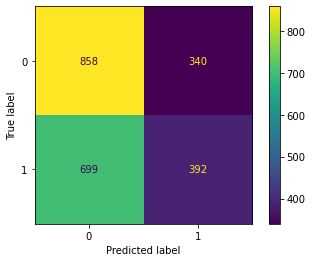

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# generate the conf matrix
conf_mat = confusion_matrix(y_test, log_reg.predict(X_test))

# plot
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

In [103]:
# Put the coefficients into a DataFrame
coefs = pd.DataFrame(data=log_reg.coef_, columns=X_train.columns).T
coefs = coefs.rename(columns={0: 'coefs'})

# Display the 20 most positive coefs
coefs.sort_values(by='coefs', ascending=False)

,coefs
point_value,0.165378
down_5,0.065555
up_10,0.042913
left_side,0.041596
up_5,0.035497
follows_make,0.035184
down_10,0.005270
score_differential,0.000610
time_remaining_secs,0.000260
x_coordinate,0.000072
